In [21]:
from api_key import key

In [22]:
import os 
import openai

openai.api_key = key

In [ ]:
# METHOD 1: MCTS

import random
import math
import time
from copy import deepcopy


# dictionary of attributes 

attributes = {
    'color': ['red', 'green', 'ivory', 'yellow', 'blue'],
    'nationality': ['Englishman', 'Spaniard', 'Ukrainian', 'Norwegian', 'Japanese'],
    'pet': ['dog', 'snail', 'fox', 'horse', 'zebra'],
    'drink': ['coffee', 'tea', 'milk', 'orange juice', 'water'],
    'hobby': ['dancing', 'painting', 'reading', 'football', 'chess']
}


# Function for creating an empty node

def start_state():
    return {attr: {} for attr in attributes}


# Function checks if each attribute dictionary has 5 entries 

def full_attributes(state):
    return all(len(state[attribute]) == 5 for attribute in attributes)


# Function creates a list of all possible remaining moves

def all_moves(state):
    remaining_moves = []
    for attribute, values in attributes.items():
        assigned = set(state[attribute].values())
        for each_house in range(5):
            if each_house not in state[attribute]:
                for value in values:
                    if value not in assigned:
                        remaining_moves.append((attribute, each_house, value))
    return remaining_moves



# Function which creates a new state 

def make_state(state, move):
    attribute, house, value = move
    new_state = deepcopy(state)
    new_state[attribute][house] = value
    return new_state



# Function uses ChatGPT LLM to complete the entire state

def complete_state(partial_state):
    
# Creates prompt to feed to LLM
    prompt = f"""
You are solving the Zebra Puzzle.

Here is the current partial state JSON:
{partial_state}

Complete the state by assigning values to all empty entries, such that all 15 constraints of the Zebra Puzzle are satisfied. Only use each value once per attribute. Return the completed state JSON only.
"""

# Feeds prompt to LLM
    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.5
    )
# Extracts text from LLM response and returns as dictionary
    text = response.choices[0].message.content
    return eval(text)



# Function which evaluates how well LLM-constructed dictionary fulfills all 15 constraints

def evaluate_conditions(state):
    color = state['color']
    nationality = state['nationality']
    pet = state['pet']
    drink = state['drink']
    hobby = state['hobby']

# Function which assesses if conditions ('attribute_dict') are met by 'val' and returns the house index
    def check_house(attribute_dict, val):
        for house_index, v in attribute_dict.items():
            if v == val:
                return int(house_index)
        return None

# Creates empty dictionary which will be used to document how many of the 15 conditions are met
    results = {}

# CONDITON 1: There are five houses.
    results[1] = len(color) == 5 and all(len(attribute) == 5 for attribute in state.values())
# CONDITION 2: The Englishman lives in the red house.
    results[2] = check_house(nationality, 'Englishman') == check_house(color, 'red')
# CONDITION 3: The Spaniard owns the dog.
    results[3] = check_house(nationality, 'Spaniard') == check_house(pet, 'dog')
# CONDITION 4: The person in the green house drinks coffee.
    results[4] = check_house(color, 'green') == check_house(drink, 'coffee')
# CONDITION 5: The Ukrainian drinks tea.
    results[5] = check_house(nationality, 'Ukrainian') == check_house(drink, 'tea')
# Gets indexes of the green and ivory house
    green_house = check_house(color, 'green')
    ivory_house = check_house(color, 'ivory')
# CONDITION 6: The green house is immediately to the right of the ivory house.
    results[6] = (green_house == ivory_house + 1) if (green_house is not None and ivory_house is not None) else False
# CONDITION 7: The snail owner likes to go dancing. 
    results[7] = check_house(pet, 'snail') == check_house(hobby, 'dancing')
# CONDITION 8: The person in the yellow house is a painter.
    results[8] = check_house(color, 'yellow') == check_house(hobby, 'painter')
# CONDITION 9: The person in the middle house drinks milk.
    results[9] = drink.get(2) == 'milk'
# CONDITION 10: The Norwegian lives in the first house.
    results[10] = nationality.get(0) == 'Norwegian'
# Gets indexes of the house with the reader and the house with the fox
    reading_house = check_house(hobby, 'reading')
    fox_house = check_house(pet, 'fox')
# CONDITION 11: The person who enjoys reading lives in the house next to the person with the fox. 
    results[11] = abs(reading_house - fox_house) == 1 if (reading_house is not None and fox_house is not None) else False
# Gets indexes of the house with the painter and the house with the horse.
    painter_house = check_house(hobby, 'painter')
    horse_house = check_house(pet, 'horse')
# CONDITION 12: The painter's house is next to the house with the horse.
    results[12] = abs(painter_house - horse_house) == 1 if (painter_house is not None and horse_house is not None) else False
# CONDITION 13: The person who plays football drinks orange juice.
    results[13] = check_house(hobby, 'football') == check_house(drink, 'orange juice')
# CONDITION 14: The Japanese person plays chess.
    results[14] = check_house(nationality, 'Japanese') == check_house(hobby, 'chess')
# Gets indexes of the house with the Norwegian and the blue house
    norwegian_house = check_house(nationality, 'Norwegian')
    blue_house = check_house(color, 'blue')
# CONDITION 15: The Norwegian lives next to the blue house.
    results[15] = abs(norwegian_house - blue_house) == 1 if (norwegian_house is not None and blue_house is not None) else False

# Returns the total amount of conditions met
    total = sum(results.values())
    return total

# Node Class

class Node:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent
        self.children = []
        self.visits = 0
        self.total_score = 0
        self.possible_moves = all_moves(state)

# Function which calculates the UCB score
    def ucb_score(self, N):
        if self.visits == 0:
            return float('inf')
        
        calculated_ucb = self.total_score / self.visits + 1.4 * math.sqrt(math.log(N) / self.visits)
        return calculated_ucb

# Function which returns the child node with the best ucb score
    def best_child(self):
        return max(self.children, key=lambda child: child.ucb_score(self.visits))


# Function which expands the node
    def expand(self):
        if not self.possible_moves:
            return None
        move = self.possible_moves.pop()
        new_state = make_state(self.state, move)
        child_node = Node(new_state, parent=self)
        self.children.append(child_node)
        return child_node


# Function which does the Monte Carlo Tree Search

def mcts(root_state, max_iter=10):
    root = Node(root_state)
    best_score = -1
    best_completed = None


    for _ in range(max_iter):
        node = root

        # Selection process: keeps descending to the best child as long as the node is fully expanded
        while node.children and not node.possible_moves:
            node = node.best_child()

        # Expansion process: creates new child node as long as there are moves to be made and current state is not fully filled 
        if not full_attributes(node.state) and node.possible_moves:
            node = node.expand()

        # Simulation process: populates the rest of the state 
        completed = complete_state(node.state)

        # Evaluation process: evaluates how many conditions are met
        score = evaluate_conditions(completed)

        # Backpropagation process: updates visit and score counts from leaf node back up to the root
        while node:
            node.visits = node.visits + 1
            node.total_score += score
            node = node.parent

        # tracks the best state and best score
        if score > best_score:
            best_score = score
            best_completed = completed

    return best_completed, best_score


# Function which runs MCTS iteratively and provides the times it takes to do each trial, the total scores, and the success rates 

def trials(num_trials=10, max_iter=50):
    times = []
    scores = []
    success_rates = []

    for i in range(num_trials):
        start = time.time()
        final_state, score = mcts(start_state(), max_iter)
    # Calculates the percentage of conditions met
        success_rate = score / 15
        success_rates.append(success_rate)
    # Calculates computational time
        elapsed_time = time.time() - start
        times.append(elapsed_time)
        scores.append(score)
        print(f"Trial {i+1}: Score = {score}, Time = {elapsed_time:.2f}s")

    return times, scores, success_rates



if __name__ == "__main__":
    times, scores, success_rates = trials(5, 50)







In [51]:
# METHOD 2: CSP

from constraint import Problem, AllDifferentConstraint


houses = range(1, 6)


# Function that checks if one index is to the right of another
def right_of(h1, h2): 
    return h1 == h2 + 1

# Function that checks if one index is next to another
def next_to(h1, h2): 
    return abs(h1 - h2) == 1

# Function that checks if index of one condition is the same as the other
def same(x, y):          
    return x == y

# Function checks if condition has index of 1 
def is_house1(x):       
    return x == 1

# Function checks if condition has index of 3
def is_house3(x):      
    return x == 3


conditions = [
    (same, ("nationality_Englishman", "color_red")),
    (same, ("nationality_Spaniard", "pet_dog")),
    (same, ("color_green", "drink_coffee")),
    (same, ("nationality_Ukrainian", "drink_tea")),
    (right_of, ("color_green", "color_ivory")),
    (same, ("pet_snail", "hobby_dancing")),
    (same, ("color_yellow", "hobby_painting")),
    (is_house3, ("drink_milk",)),
    (is_house1, ("nationality_Norwegian",)),
    (next_to, ("hobby_reading", "pet_fox")),
    (next_to, ("hobby_painting", "pet_horse")),
    (same, ("hobby_football", "drink_orange juice")),
    (same, ("nationality_Japanese", "hobby_chess")),
    (next_to, ("nationality_Norwegian", "color_blue")),
]


# Function that calculates comp
def new_solve_csp() -> tuple[int, float]:
    problem = Problem()
# creates variable for each value of an attribute
    for attribute, values in attributes.items():
        for v in values:
            problem.addVariable(f"{attribute}_{v}", houses)
# constraint that all 5 attribute values must go in different houses
        problem.addConstraint(AllDifferentConstraint(), [f"{attribute}_{v}" for v in values])

# Adds each clue as a constraint to the solver
    for constraint_function, description in conditions:
        problem.addConstraint(constraint_function, description)

# Calculates computational time and accuracy rate
    start_time = time.time()
    solution = problem.getSolution()
    total_time = time.time() - start_time
    return (float(100) if solution else None), total_time



# Iterates 5 times to get various values for time and accuracy scores
accuracy_records = []
time_records = []

for trial in range(1, 6):
    solved, seconds = new_solve_csp()
    accuracy_records.append(solved)
    time_records.append(seconds)



In [ ]:
# METHOD 3: Backtracking



# Function that returns the house index if attribute matches the value
def assess(houses, attribute, value):
    for index, valu in enumerate(houses):
        if valu.get(attribute) == value:
            return index
    return None


# Function which counts the number of conditions that are met
def count_constraints(houses):
    score = 0
        # Condition 1: There are five houses.
    if len(houses) == 5:
            score += 1

        # Condition 2: The Englishman lives in the red house.
    if assess(houses, "nationality", "Englishman") == assess(houses, "color", "red"):
            score += 1

        # Condition 3: The Spaniard owns the dog.
    if assess(houses, "nationality", "Spaniard") == assess(houses, "pet", "dog"):
        score += 1

        # Condition 4: The person in the green house drinks coffee.
    if assess(houses, "color", "green") == assess(houses, "drink", "coffee"):
        score += 1

        # Condition 5: The Ukrainian drinks tea.
    if assess(houses, "nationality", "Ukrainian") == assess(houses, "drink", "tea"):
        score += 1

        # Condition 6: The green house is immediately to the right of the ivory house.
    if assess(houses, "color", "green") == assess(houses, "color", "ivory") + 1:
        score += 1

        # Condition 7: The snail owner likes to go dancing.
    if assess(houses, "pet", "snail") == assess(houses, "hobby", "dancing"):
        score += 1

        # Condition 8: The person in the yellow house is a painter.
    if assess(houses, "color", "yellow") == assess(houses, "hobby", "painting"):
        score += 1

        # Condition 9: The person in the middle house drinks milk.
    if assess(houses, "drink", "milk") == 2:
        score += 1

        # Condition 10: The Norwegian lives in the first house.
    if assess(houses, "nationality", "Norwegian") == 0:
        score += 1

        # Condition 11: The person who enjoys reading lives next to the person with the fox.
    if abs(assess(houses, "hobby", "reading") - assess(houses, "pet", "fox")) == 1:
        score += 1

        # Condition 12: The painter's house is next to the house with the horse.
    if abs(assess(houses, "hobby", "painting") - assess(houses, "pet", "horse")) == 1:
        score += 1

        # Condition 13: The person who plays football drinks orange juice.
    if assess(houses, "hobby", "football") == assess(houses, "drink", "orange juice"):
        score += 1

        # Condition 14: The Japanese person plays chess.
    if assess(houses, "nationality", "Japanese") == assess(houses, "hobby", "chess"):
        score += 1

        # Condition 15: The Norwegian lives next to the blue house.
    if abs(assess(houses, "nationality", "Norwegian") - assess(houses, "color", "blue")) == 1:
        score += 1

    return score  


# Function that makes sure values assigned are not repeated

def is_valid(houses, assignment):
    for house in houses:
        for _, val in assignment.items():
            if val in house.values():
                return False
    return True



# Function checks if certain house arrangement satisfies all the conditions 

def check_arrangement(houses):

    try:
        # Condition 1: There are five houses.
        if len(houses) != 5:
            return False

        # Condition 2: The Englishman lives in the red house.
        first_part = assess(houses, "nationality", "Englishman")
        if first_part is not None:
            second_part = assess(houses, "color", "red")
            if second_part is not None and first_part != second_part:
                return False

        # Condition 3: The Spaniard owns the dog.
        first_part = assess(houses, "nationality", "Spaniard")
        if first_part is not None:
            second_part = assess(houses, "pet", "dog")
            if second_part is not None and first_part != second_part:
                return False

        # Condition 4: The person in the green house drinks coffee.
        first_part = assess(houses, "color", "green")
        if first_part is not None:
            second_part = assess(houses, "drink", "coffee")
            if second_part is not None and first_part != second_part:
                return False

        # Condition 5: The Ukrainian drinks tea.
        first_part = assess(houses, "nationality", "Ukrainian")
        if first_part is not None:
            second_part = assess(houses, "drink", "tea")
            if second_part is not None and first_part != second_part:
                return False

        # Condition 6: The green house is immediately to the right of the ivory house.
        first_part = assess(houses, "color", "green")
        if first_part is not None:
            second_part = assess(houses, "color", "ivory")
            if second_part is not None and first_part != second_part + 1:
                return False

        # Condition 7: The snail owner likes to go dancing.
        first_part = assess(houses, "pet", "snail")
        if first_part is not None:
            second_part = assess(houses, "hobby", "dancing")
            if second_part is not None and first_part != second_part:
                return False

        # Condition 8: The person in the yellow house is a painter.
        first_part = assess(houses, "color", "yellow")
        if first_part is not None:
            second_part = assess(houses, "hobby", "painting")
            if second_part is not None and first_part != second_part:
                return False

        # Condition 9: The person in the middle house drinks milk.
        first_part = assess(houses, "drink", "milk")
        if first_part is not None and first_part != 2:
            return False

        # Condition 10: The Norwegian lives in the first house.
        first_part = assess(houses, "nationality", "Norwegian")
        if first_part is not None and first_part != 0:
            return False

        # Condition 11: The person who enjoys reading lives next to the person with the fox.
        first_part = assess(houses, "hobby", "reading")
        if first_part is not None:
            second_part = assess(houses, "pet", "fox")
            if second_part is not None and abs(first_part - second_part) != 1:
                return False

        # Condition 12: The painter's house is next to the house with the horse.
        first_part = assess(houses, "hobby", "painting")
        if first_part is not None:
            second_part = assess(houses, "pet", "horse")
            if second_part is not None and abs(first_part - second_part) != 1:
                return False

        # Condition 13: The person who plays football drinks orange juice.
        first_part = assess(houses, "hobby", "football")
        if first_part is not None:
            second_part = assess(houses, "drink", "orange juice")
            if second_part is not None and first_part != second_part:
                return False

        # Condition 14: The Japanese person plays chess.
        first_part = assess(houses, "nationality", "Japanese")
        if first_part is not None:
            second_part = assess(houses, "hobby", "chess")
            if second_part is not None and first_part != second_part:
                return False

        # Condition 15: The Norwegian lives next to the blue house.
        first_part = assess(houses, "nationality", "Norwegian")
        if first_part is not None:
            second_part = assess(houses, "color", "blue")
            if second_part is not None and abs(first_part - second_part) != 1:
                return False

    except Exception:
        return False

    return True



# Function recursively builds a solution by assigning unused attribute values to each house
def backtrack_solver(index, houses, available_attributes):
    if index == 5:
        return deepcopy(houses)

# Iterates through each value within each attribute to consider all possible combinations 
    for color in available_attributes['color']:
        for nationality in available_attributes['nationality']:
            for drink in available_attributes['drink']:
                for pet in available_attributes['pet']:
                    for hobby in available_attributes['hobby']:
                        assigned = {
                            'color': color,
                            'nationality': nationality,
                            'drink': drink,
                            'pet': pet,
                            'hobby': hobby
                        }
                    # Filters out values that are repeated
                        if not is_valid(houses, assigned):
                            continue

                    # Puts chosen values into appropriate house
                        houses[index] = assigned
                    
                    # Removes value from being selected in available attributes
                        for attribute in attributes:
                            available_attributes[attribute].remove(assigned[attribute])

                    # Filters out if any conditions are unavailable
                        if check_arrangement(houses):
                            result = backtrack_solver(index + 1, houses, available_attributes)
                            if result:
                                return result

                    # Adds value so it can be selected for the next iteration
                        for attribute in attributes:
                            available_attributes[attribute].add(assigned[attribute])
                        houses[index] = {}
    return None



# Function which finds the valid solution to the puzzle

def solve_backtracking():
    houses = [{} for _ in range(5)]
    unused_vals = {attribute: set(vals) for attribute, vals in attributes.items()}

# Calculates computational time
    start = time.time()
    final_state = backtrack_solver(0, houses, unused_vals)
    end = time.time()

# Calculates accuracy score 
    if final_state:
        score = count_constraints(final_state) / 15 
    else:
        score = 0.0

    return score, end - start

In [31]:
backtrack_success = []
backtrack_time = []

# Iterates 5 times to get multiple values for success_rate and computational time 

for _ in range(5):
    s, t = solve_backtracking()
    backtrack_success.append(s)
    backtrack_time.append(t)

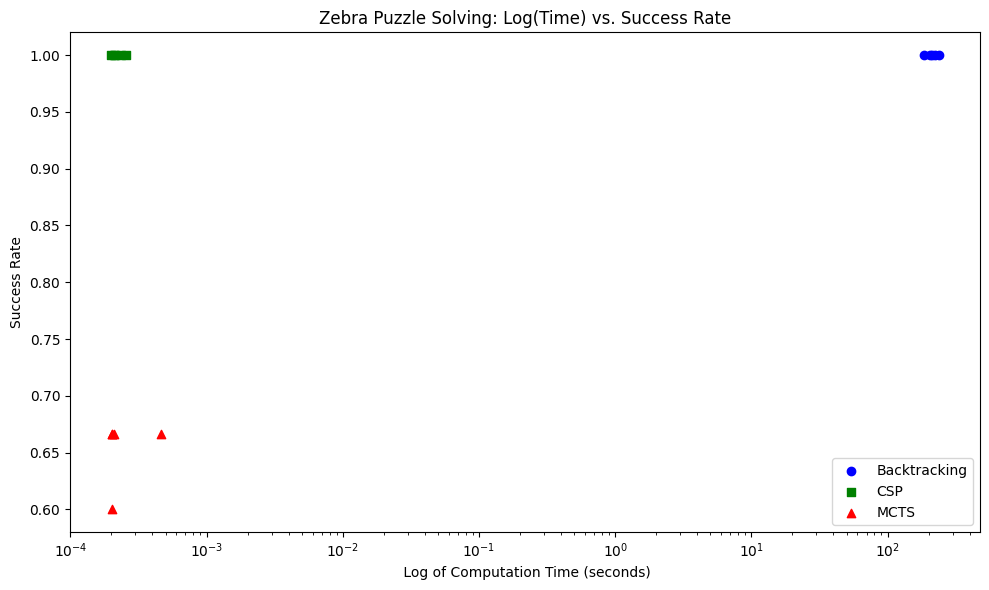

In [35]:
# Plots the score percentage and computational times of all 3 methods

import matplotlib.pyplot as plt



plt.figure(figsize=(10, 6))

plt.scatter(backtrack_time, backtrack_success, color='blue', label='Backtracking', marker='o')
plt.scatter(time_records, accuracy_records, color='green', label='CSP', marker='s')
plt.scatter(times, success_rates, color='red', label='MCTS', marker='^')



plt.xlabel(" Log of Computation Time (seconds)")
plt.ylabel("Success Rate")
plt.title("Zebra Puzzle Solving: Log(Time) vs. Success Rate")
plt.legend()

plt.xscale('log')

plt.tight_layout()
plt.show()

